In [25]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# storing 
import numpy as np
import pandas as pd
import calmap
import warnings
import itertools
import wget
import os
import shutil
import datetime
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU, WeekdayLocator
from scipy.fftpack import fft
from scipy.signal import butter, lfilter, freqz, stft
warnings.filterwarnings('ignore')
dataPath = '../data/'
pd.set_option('display.max_columns', None)
from IPython.display import HTML

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### 0. Functions
- Run below cell once

In [67]:
{
    "tags": [
        "hide_input",
    ]
}

def Update_Data():
    urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
            'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv']

    for url in urls:
        filename = wget.download(url)
        os.remove(dataPath + filename)
        newPath = shutil.move(filename, dataPath[0:-1])
        
    conf_df = pd.read_csv(dataPath + 'time_series_covid19_confirmed_global.csv')
    deaths_df = pd.read_csv(dataPath + 'time_series_covid19_deaths_global.csv') 
    conf_df = update_initial_dfs(conf_df)
    deaths_df = update_initial_dfs(deaths_df)
    return conf_df, deaths_df

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creates a row for each individual country: (Aggregates)
def create_aggregates_dataframe(df):
    province_states_unique = df["Province/State"].unique()#.dropna().unique()
    dfAggregates = df[df['Province/State'].isin(province_states_unique)]
    country_region_aggregates = dfAggregates['Country/Region'].unique()

    for i, agg_country in enumerate(country_region_aggregates):
        lstRow = []
        dfTemp = dfAggregates[dfAggregates['Country/Region'] == agg_country]
        provState = agg_country + '_Total'                             # Countries with the sum of their states
        lat = dfTemp.Lat.sum()/len(dfTemp)                             # i.e. Australia with Victoria, NSW etc aggregated
        long = dfTemp.Long.sum()/len(dfTemp)
        rowEntries = [provState, agg_country, lat, long]
        lstRow = [elem for elem in rowEntries] 
        for col in dfTemp.columns[4:]:
            col_j_aggregate = dfTemp[col].sum()
            lstRow.append(col_j_aggregate)
        lstRow = pd.DataFrame([lstRow], columns = dfTemp.columns)
        df = df.append(lstRow)
        
    df_list = []
    for i, agg_country in enumerate(country_region_aggregates):    
        country_df = df[df['Country/Region'] == agg_country]
        uniqueProvs = country_df['Province/State'].unique()
        country_df = country_df[(country_df['Province/State'].isnull()) | (country_df['Province/State'].str.contains('_Total'))]
        if len(country_df) > 1:
            #country_df.drop([country + '_Total'], axis = 0, inplace = True)
            country_df = country_df[country_df['Province/State'] != agg_country + '_Total']
        df_list.append(country_df)
    df = pd.concat(df_list)
    df.drop(['Province/State'], axis = 1, inplace = True)
    return df
        
def create_changes_dataframe(df):
    
    province_states_unique = df["Province/State"].unique()#.dropna().unique()
    dfAggregates = df[df['Province/State'].isin(province_states_unique)]
    country_region_aggregates = dfAggregates['Country/Region'].unique()
    
    # STEP_1:
    # Some countries have individual states listed: Aggregate state-values together to gain actual country values
    for i, agg_country in enumerate(country_region_aggregates):
        lstRow = []
        dfTemp = dfAggregates[dfAggregates['Country/Region'] == agg_country]
        if len(dfTemp) > 1:
            provState = agg_country + '_Total'         # Countries with the sum of their states
            lat = dfTemp.Lat.sum()/len(dfTemp)         # i.e. Australia with Victoria, NSW etc aggregated
            long = dfTemp.Long.sum()/len(dfTemp)
            rowEntries = [provState, agg_country, lat, long]
            lstRow = [elem for elem in rowEntries] 
            for col in dfTemp.columns[4:]:
                col_j_aggregate = dfTemp[col].sum()
                lstRow.append(col_j_aggregate)
            lstRow = pd.DataFrame([lstRow], columns = dfTemp.columns)
            df = df.append(lstRow)
    
    df = df.sort_values(by = "Country/Region") 
    df['Province/State'].fillna(df['Country/Region'], inplace=True)  # Countries not including their colonial states
    df = df.reset_index(drop = True)                                 # i.e. United Kingdom without the "Falkland Islands"
    
    # STEP_2:
    # Make new columns to represent daily changes and convert US date-format to dd/mm/yy
    col_list = df.columns[0:4].tolist()
    for col in df.columns[4:]:
        if len(col) == 8: 
            col = "Diff_Prev_Day_" + col[3:5] + col[2] + col[0:2] # i.e. '12/12/20'
        elif len(col) == 7:
            col = "Diff_Prev_Day_" + col[2:4] + col[1] + col[0] # i.e.   '2/12/20'
        elif len(col) == 6:
            col = "Diff_Prev_Day_" + col[2:3] + col[1] + col[0] # i.e.   '2/2/20'
        col_list.append(col)
        
    ## STEP_3:
    # Define new dataframe to represent daily changes
    df_daily_change = pd.DataFrame(columns = col_list)
    countries_unique = df["Country/Region"].unique()
    growth_rates = []
    prevNum = 0
    len_max = len(df.columns[4:])
    
    ## STEP_4:
    # a) Iterate through each country and respective regions:
    for country in countries_unique:       
        df_country = df[df["Country/Region"] == country]
        province_states_unique = df_country["Province/State"].dropna()

        for province_state in province_states_unique:

            # b) Start dataframe recording from first registered case: (ignore all prior zero-cases on earlier dates)
            df_province_state = df_country[df_country["Province/State"] == province_state]
            df_province_state = df_province_state.loc[:, (df_province_state != 0).any(axis=0)]
            
            # d) Save first four columns (Province, Country, Lat, Long)
            #    Determine how many days prior to first case recorded (pad with 0)
            day_change_lst = df_province_state[df_province_state.columns[0:4]].values[0].tolist() 
            diff = len_max - len(df_province_state.columns[4:])
            day_change_lst += [0] * (diff) 
     
            
            # e) Calculate change from one-day to the next
            totalCases = 0
            for col in df_province_state.columns[4:]:
                new_num_cases = df_province_state[col].values[0]
                change_cases = new_num_cases - totalCases
                totalCases = new_num_cases
                day_change_lst.append(change_cases)

            df_day_i_change = pd.DataFrame([day_change_lst], columns = col_list)

            if len(df_daily_change) == 0:
                df_daily_change = df_day_i_change
            else:
                df_daily_change = pd.concat([df_daily_change, df_day_i_change])
    
    return df_daily_change

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def plotDailyChanges(df, list_countries, colourList, axislabels, filterInputs, plotAbsoluteCases = False):
    
    filtering = filterInputs[0]
    Ts = filterInputs[1]
    order = filterInputs[2]
    cutoff = filterInputs[3]
    
    f = plt.figure(figsize=(20,10))
    ax = f.add_subplot("111")
    
    if plotAbsoluteCases:
        for i, country in enumerate(list_countries):
            df_ = df[df['Country/Region'] == country]
            x = df_.columns[3:].tolist()
            y = df_[df_.columns[3:]].values.tolist()[0]
            plt.plot(x, y, '<-', label = country)
            plt.legend()
        plt.xticks(rotation=45)
        plt.ylabel(axislabels[0], size = 15)
        plt.xlabel("Date", size = 15)
        loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(loc)
        return
            
    else:
        df_plot = pd.DataFrame()
        base = datetime.date(2020, 1, 22)
        numdays = len(df.columns[4:])
        date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]
        province_states_unique = df["Province/State"].unique()
        inputVariable = "DayChanges"
        j = 0
        for province_state in province_states_unique:
            df_province_state = df[df["Province/State"] == province_state]
            dayChanges = df_province_state[df_province_state.columns[4:]].values[0]

            if max(dayChanges) > 0 and (province_state in list_countries):
                #j += 1
                if j%1 == 0:
                    colour = colourList[j]
                    j += 1
                    df_plot["dates"] = date_list
                    df_plot["DayChanges"] = dayChanges
                    #df_plot["growth_rates"] = df_plot["growth_rates"].rolling(3).mean()
                    if filtering:
                        y_filtered = lowPass_butterworth(df_plot, inputVariable, cutoff, order, Ts)
                        df_plot["y_filtered"] = y_filtered
                        df_plot["y_filtered"] = df_plot["y_filtered"].rolling(3).mean()
                        if j%2 == 0:
                            plt.bar(df_plot.dates,  df_plot["y_filtered"], color = colour, label = province_state, linewidth = 1, alpha = 0.2)
                        else:
                            plt.bar(df_plot.dates,  df_plot["y_filtered"], color = colour, label = province_state, linewidth = 1, alpha = 0.2)
                    else:
                         plt.plot(df_plot.dates, df_plot.DayChanges, "-o", color = colour, label = province_state, linewidth = 1, alpha = 0.2)

            #break
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    #import matplotlib.dates.WeekdayLocator
    # tick on mondays every week
    #loc = WeekdayLocator(byweekday=MO, tz=tz)

    # tick on mondays and saturdays
    loc = WeekdayLocator(byweekday=(MO,FR))
    ax.xaxis.set_major_locator(loc)
    plt.xticks(rotation=45)
    plt.ylabel(axislabels[0], size = 15)
    plt.xlabel("Date", size = 15)
    #plt.xlim(df_plot.dates[15], df_plot.dates[len(df_plot.dates) - 1])
    plt.gca().set_xlim(left=df_plot.dates[20])
    plt.title(axislabels[1], size = 20)
    #plt.ylim([-1, 100])
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()
    

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def getcolour():
    return np.random.rand(3,)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------
def lowpass_butterworth(y, cutoff, order, Ts):
   
    # Detrend
    y_ = y - sum(y)/len(y)
    #print(y)
    
    # Low-pass calculation
    fs = 1 / Ts
    b, a = return_filter_coeffs(cutoff, fs, order=order)
    y_butter = lfilter(b, a, y_) + sum(y) / len(y)
    
    return y_butter

def lowPass_butterworth(io_signal, inputVariable, cutoff, order, Ts):
    #### Try cut-off frequency of cutoff units

    # Signal
    variable = inputVariable #+ str(gainNum) 
    
    # Detrend
    y = io_signal[variable].dropna() - (io_signal[variable].dropna()).sum() / len(io_signal[variable].dropna())
    #print(y[0:5])
    # Sample-rate
    fs = 1 / Ts
    #print(fs)
    # Low-pass calculation
    b, a = butter_lowpass(cutoff, fs, order=order)
    y_butter = lfilter(b, a, y) + (io_signal[variable].dropna()).sum() / len(io_signal[variable].dropna())
    #offset = min(y.dropna().index.values)

    #brewCycle = np.linspace(0, brew_curr.BrwDurationSec.dropna(), len(brew_curr.BrwDurationSec.dropna()), endpoint=False)
    #sample = np.linspace(offset, len(y_butter) + offset, len(y_butter), endpoint=False)
    
    return y_butter

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def return_filter_coeffs(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# ---------------------------------------------------------------------------------------------------------------------

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = return_filter_coeffs(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def update_initial_dfs(df):
    
    province_states_unique = df["Province/State"].unique()#.dropna().unique()
    dfAggregates = df[df['Province/State'].isin(province_states_unique)]
    country_region_aggregates = dfAggregates['Country/Region'].unique()

    for i, agg_country in enumerate(country_region_aggregates):
        lstRow = []
        dfTemp = dfAggregates[dfAggregates['Country/Region'] == agg_country]
        if len(dfTemp) > 1:
            provState = agg_country #+ '_Total'          # Countries with the sum of their states
            lat = dfTemp.Lat.sum()/len(dfTemp)          # i.e. Australia with Victoria, NSW etc aggregated
            long = dfTemp.Long.sum()/len(dfTemp)
            rowEntries = [provState, agg_country, lat, long]
            lstRow = [elem for elem in rowEntries] 
            for col in dfTemp.columns[4:]:
                col_j_aggregate = dfTemp[col].sum()
                lstRow.append(col_j_aggregate)
            lstRow = pd.DataFrame([lstRow], columns = dfTemp.columns)
            df = df.append(lstRow)
    
    df = df.sort_values(by = "Country/Region") 
    df['Province/State'].fillna(df['Country/Region'], inplace=True) # Countries not including their colonial states
    df = df.reset_index(drop = True)                                # i.e. United Kingdom without the "Falkland Islands"

    return df

#### 1. Update Datasets
- Run below cell once

In [12]:
conf_df, deaths_df = Update_Data()
changes_conf_df = create_changes_dataframe(conf_df)
changes_deaths_df = create_changes_dataframe(deaths_df)

100% [..........................................................] 90065 / 90065

#### 2. EDA: Visualisation of several countries

##### Here we will analyse 4 parts of the world:
1. Selected European Countries/Neighbours
        - Part 1: Germany, Sweden, United Kingdom, Russia
        - Part 2: France, Italy, Spain, Turkey
- North & South America
        - USA, Canada, Brazil, Mexico
- Asia
        - South Korea, India, China, Afghanistan
- Australia (with states) & New Zealand
        - Victoria, New South Wales, Australia-Total, New Zealand

##### Define required variables:

In [32]:
dict_candidates = {}
dict_candidates['Europe A'] = ['Germany', 'Sweden', 'United Kingdom', 'Russia']
dict_candidates['Europe B'] = ['France', 'Italy', 'Spain', 'Turkey']
dict_candidates['Asia'] = ['Korea, South', 'India', 'China', 'Afghanistan']
dict_candidates['North & South America'] = ['US', 'Canada', 'Brazil', 'Mexico']
dict_candidates['Australia & New Zealand'] = ['Australia', 'New Zealand', 'Victoria', 'New South Wales']
listProvinces = conf_df['Province/State'].unique().tolist()
x = conf_df.columns[4:].tolist()

In [35]:
print(len(dict_candidates)), 'number of cases', 'confirmed cases'

5


In [42]:
def plotResults(df, labels, dict_candidates_, log_scaling = False, filtering = False):
    f = plt.figure(figsize=(15,15))

    for i, region in enumerate(dict_candidates_):  
        axi = f.add_subplot(str(len(dict_candidates_)) +"1" + str(i + 1))

        for j, location in enumerate(dict_candidates_[region]):
            y = df[df['Province/State'] == location].values[0][4:].tolist()
            plt.plot(x, y, alpha = 0.5, linewidth = 2, label = location)

        plt.xticks(rotation=45)
        plt.xlabel("date", size = 15)
        loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
        axi.xaxis.set_major_locator(loc)
        plt.ylabel(labels[0], size = 15)
        plt.title(region, size = 20)
        plt.legend()

        if log_scaling: 
            axi.set_yscale('log')
            plt.ylim([0, 10e6])

    plt.suptitle(labels[1] + " for selected countries", size = 20)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.92, wspace=None, hspace=None)

In [70]:
def plotResults(df, labels, dict_candidates_, log_scaling = False, stemplot = False, filterInputs_ = None):
    f = plt.figure(figsize=(15,15))

    for i, region in enumerate(dict_candidates_):  
        axi = f.add_subplot(str(len(dict_candidates_)) +"1" + str(i + 1))

        for j, location in enumerate(dict_candidates_[region]):
            y = df[df['Province/State'] == location].values[0][4:].tolist()
            
            if filterInputs_ is not None:
                Ts = filterInputs_[0] 
                order = filterInputs_[1] 
                cutoff = filterInputs_[2] 
                y = lowpass_butterworth(np.array(y), cutoff, order, Ts)
                #df_plot["y_filtered"] = y_filtered
                #df_plot["y_filtered"] = df_plot["y_filtered"].rolling(3).mean()

            if stemplot:
                plt.bar(x, y, alpha = 0.5, width = 0.1, label = location)
                plt.plot(x, y,  'o')
            else:
                plt.plot(x, y, alpha = 0.5, linewidth = 2, label = location)
                
        plt.xticks(rotation=45)
        plt.xlabel("date", size = 15)
        loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
        axi.xaxis.set_major_locator(loc)
        plt.ylabel(labels[0], size = 15)
        plt.title(region, size = 20)
        plt.legend(loc = "upper left")

        if log_scaling: 
            axi.set_yscale('log')
            plt.ylim([0, 10e6])

    plt.suptitle(labels[1] + " for selected countries", size = 20)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.92, wspace=None, hspace=None)

In [ ]:
    plt.plot(dfTemp.Datetime, dfTemp.StickTime,  'o', label = AC)
    plt.bar(dfTemp.Datetime, dfTemp.StickTime,  width = 0.1, label = AC, alpha=0.5)
     

##### 2.1 Confirmed number of cases

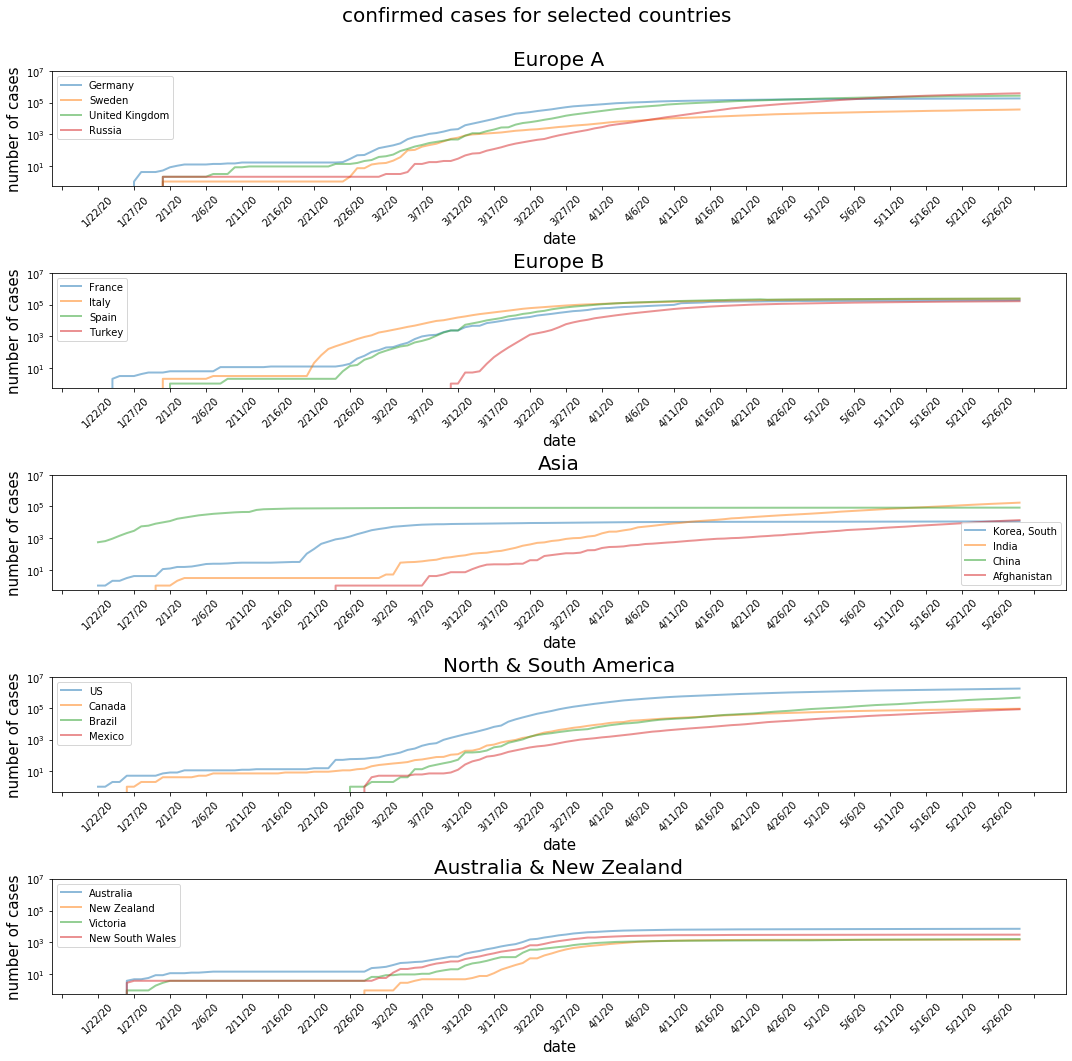

In [51]:
log_scaling = True
labels = ['number of cases', 'confirmed cases']
plotResults(conf_df, labels, dict_candidates, log_scaling)

##### 2.2 Confirmed number of deaths

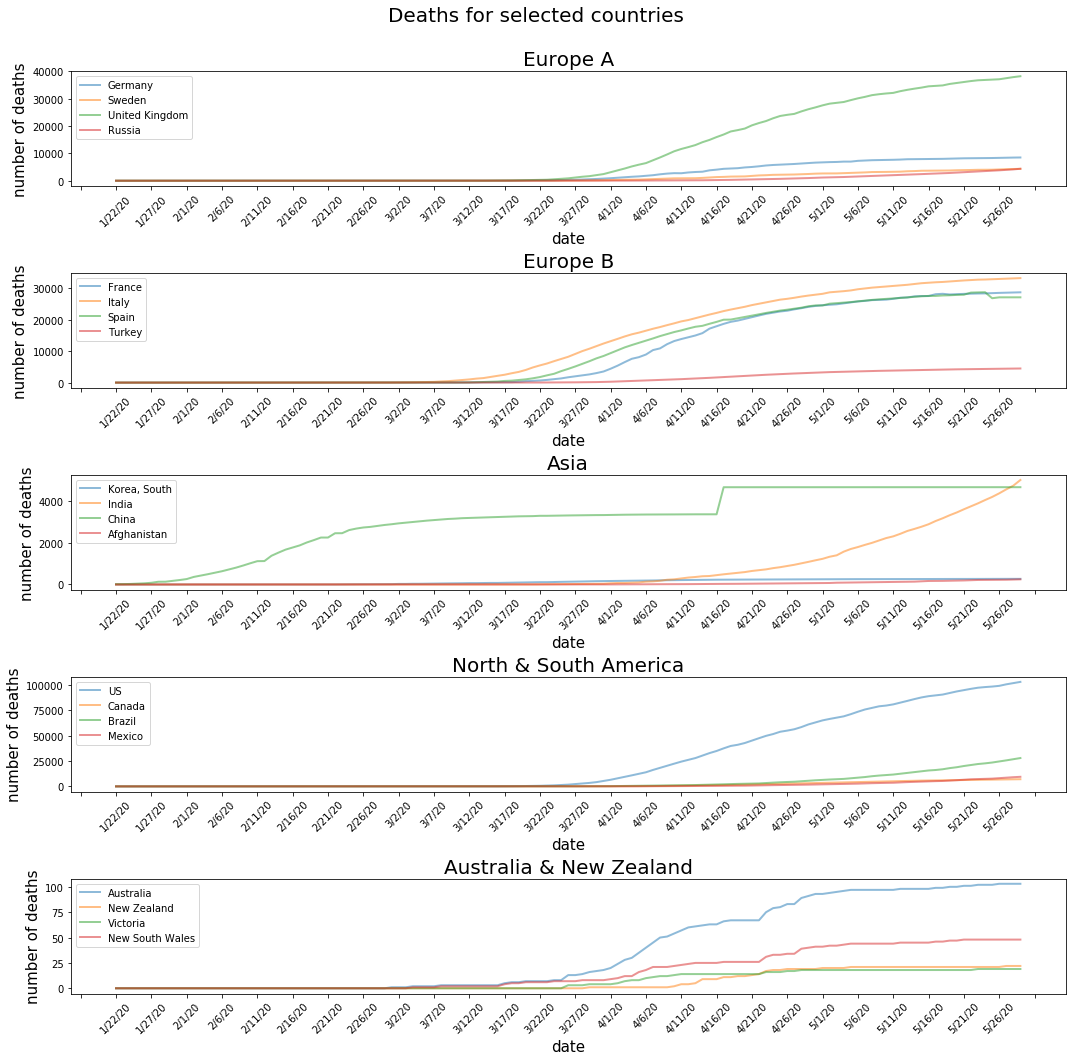

In [41]:
labels = ['number of deaths', 'Deaths']
plotResults(deaths_df, labels, dict_candidates)

##### 2.3 Newly confirmed cases per day

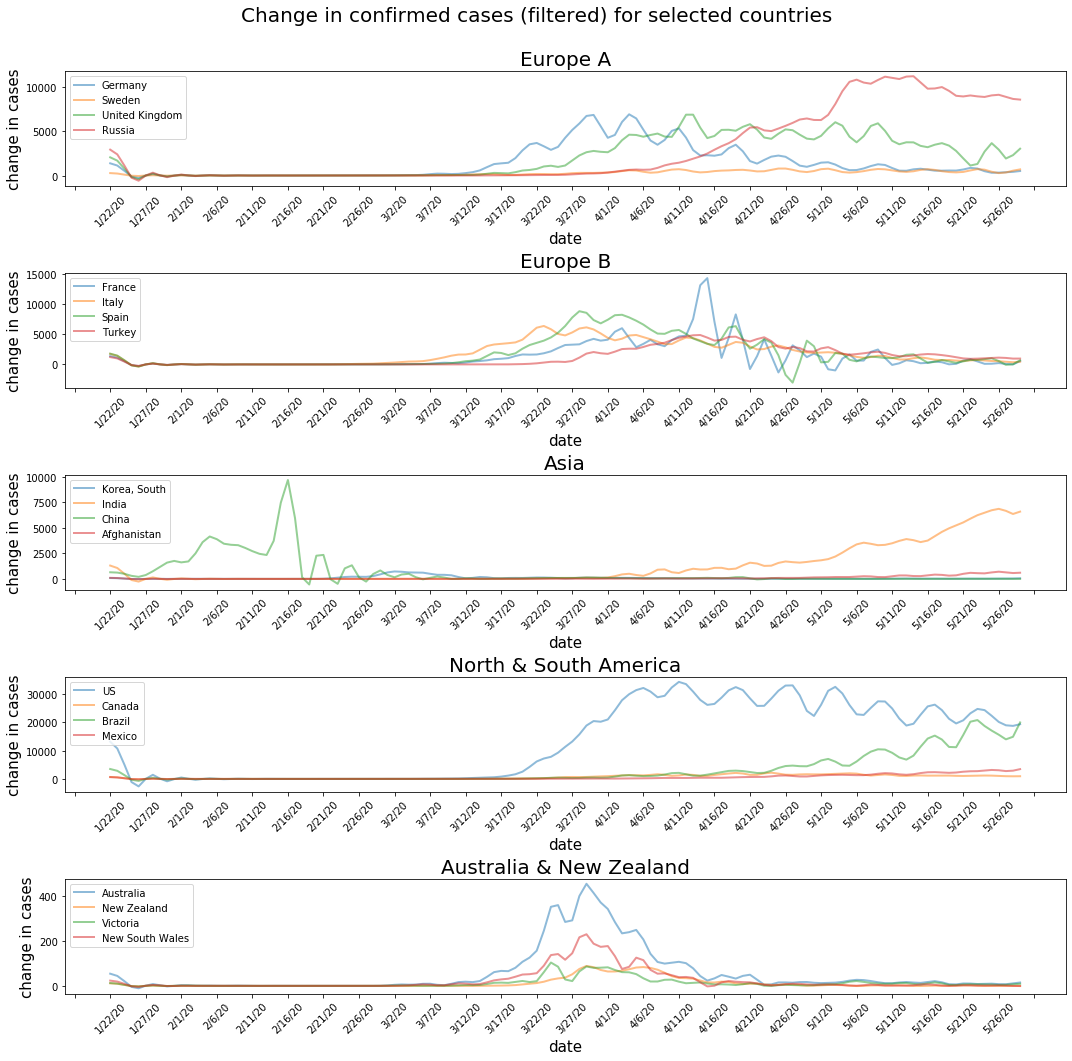

In [71]:
labels = ['change in cases', 'Change in confirmed cases (filtered)']
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [Ts, order, cutoff]
plotResults(changes_conf_df, labels, dict_candidates, filterInputs_ = filterInputs)

##### 2.3 Newly confirmed deaths per day

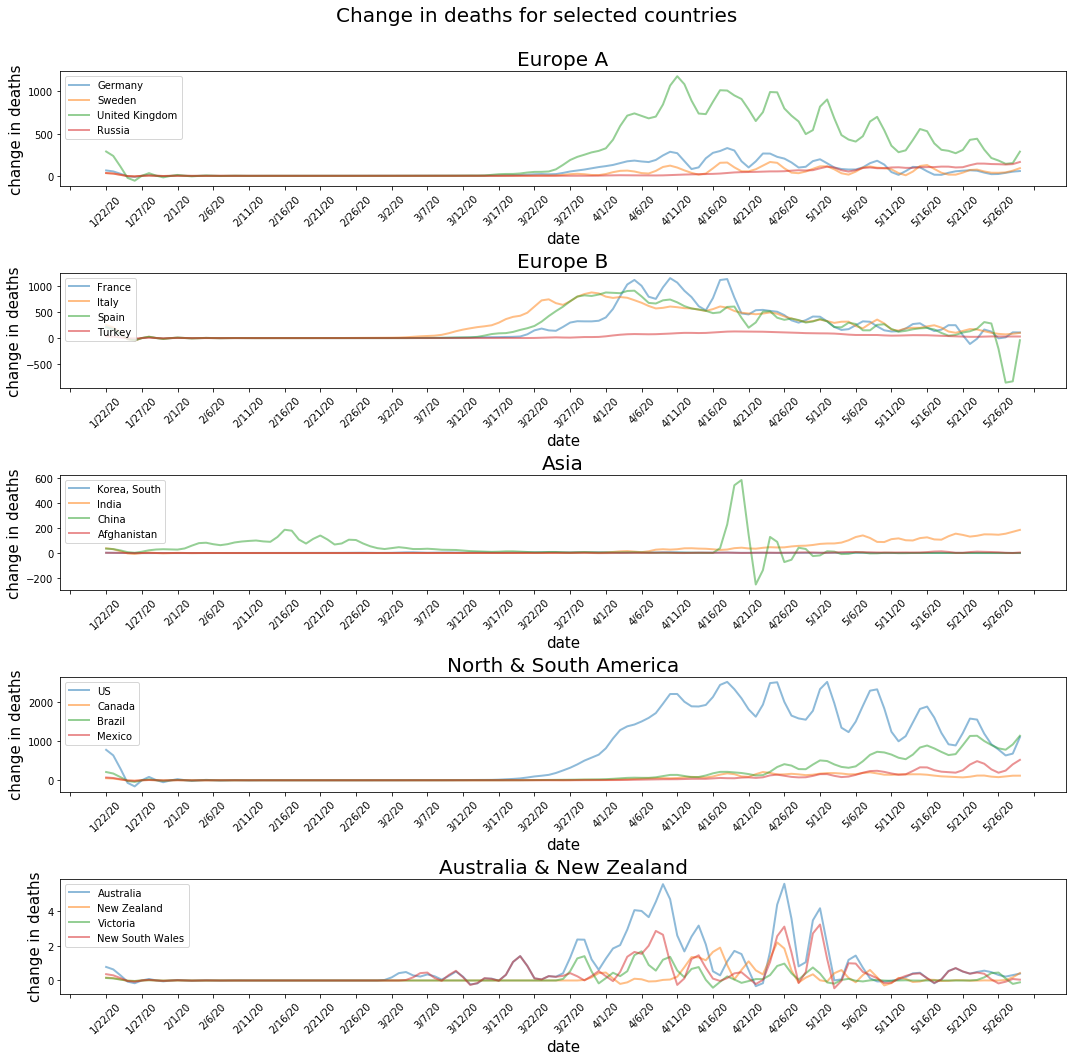

In [72]:
labels = ['change in deaths', 'Change in deaths']
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [Ts, order, cutoff]
plotResults(changes_deaths_df, labels, dict_candidates, filterInputs_ = filterInputs)

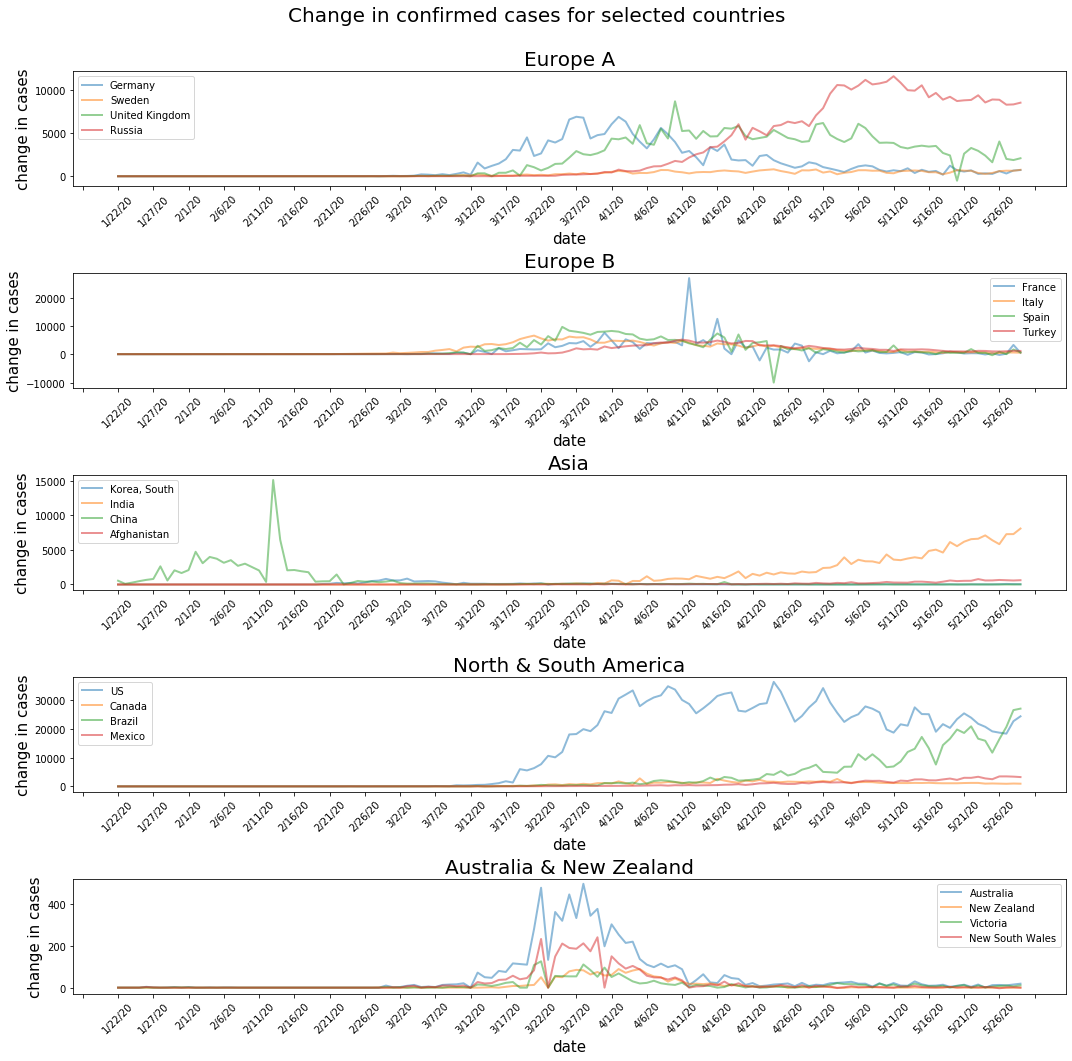

In [31]:
log_scaling = False
f = plt.figure(figsize=(15,15))
listProvinces = conf_df['Province/State'].unique().tolist()
x = conf_df.columns[4:].tolist()

for i, region in enumerate(dict_candidates):  
    axi = f.add_subplot("51" + str(i + 1))
    for j, location in enumerate(dict_candidates[region]):
        y = changes_conf_df[changes_conf_df['Province/State'] == location].values[0][4:].tolist()
        plt.plot(x, y, alpha = 0.5, linewidth = 2, label = location)  
            
    plt.xticks(rotation=45)
    plt.ylabel('change in cases', size = 15)
    plt.xlabel("date", size = 15)
    loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
    axi.xaxis.set_major_locator(loc)
    plt.title(region, size = 20)
    plt.legend()
    
    if log_scaling: 
        axi.set_yscale('log')
        plt.ylim([0, 10e6])

plt.suptitle("Change in confirmed cases for selected countries", size = 20)
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.92, wspace=None, hspace=None)

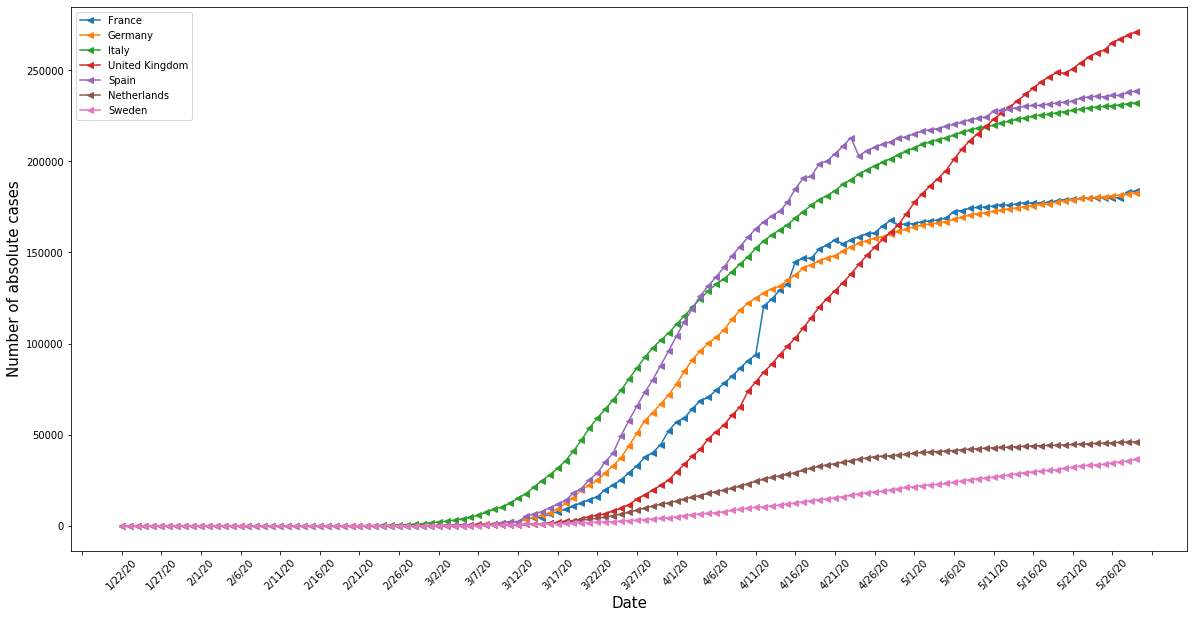

In [20]:
list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain', 'Netherlands', 'Sweden']
labels = ["Number of absolute cases", "Western Europe"]
#if 'US_Mainland' in list_countries: list_countries.remove('US_Mainland')
colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour()) # getcolour()
#labels = ["Increase in number of deaths", "Number of new deaths per day"]

filtering = False
Ts = 1 
order = 6  
cutoff = .5   # Corner frequency
filterInputs = [filtering, Ts, order, cutoff]
plotDailyChanges(cases_sum_df, list_countries, colourList, labels, filterInputs, plotAbsoluteCases = True)

##### 2.1 Aggregate number of deaths

In [ ]:
list_countries = ['Australia_Total', 'Victoria', 'New South Wales'] #'US_'
list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain', 'Netherlands', 'Sweden']

#if 'US_Mainland' in list_countries: list_countries.remove('US_Mainland')
colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())
#labels = ["Increase in number of deaths", "Number of new deaths per day"]
labels = ["Increase in number of deaths", "Western Europe"]
filtering = True
Ts = 1 
order = 6  
cutoff = 0.3
filterInputs = [filtering, Ts, order, cutoff]
plotDailyChanges(df_daily_change_death, list_countries, colourList, labels, filterInputs)

In [ ]:
list_countries = ['France_Mainland', 'US_Mainland', 'Italy_Mainland', 'United Kingdom_Mainland', 'Australia_Total', 'Victoria', 'New South Wales', 'Spain_Mainland']
list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain', 'Netherlands', 'Sweden']

#if 'US_Mainland' in list_countries: list_countries.remove('US_Mainland')
#list_countries = ['Australia_Total', 'Victoria', 'New South Wales']
colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())
axislabels = ["Increase in number of cases", "Change in new cases per day"]
filtering = True
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotDailyChanges(cases_sum_df, list_countries, colourList, axislabels, filterInputs)

##### 2.4 New-deaths per day

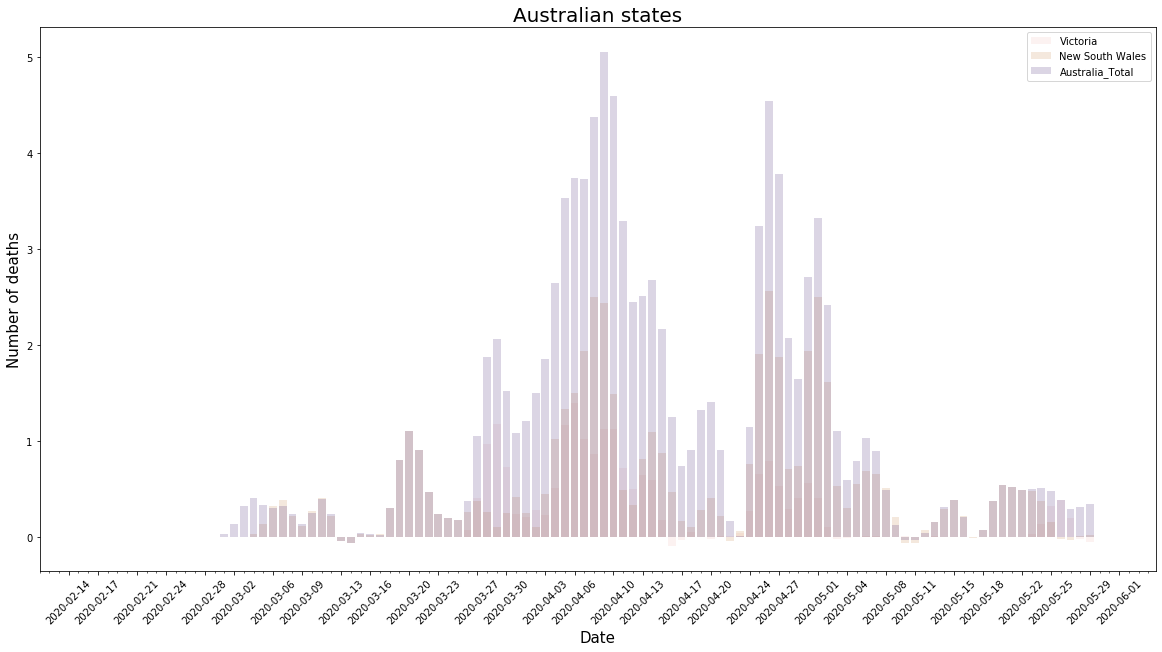

In [14]:
aus = 1
if aus:
    list_countries = ['Australia_Total', 'Victoria', 'New South Wales'] #'US_'
    labels = ["Number of deaths", "Australian states"]
else:
    list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain', 'Netherlands', 'Sweden']
    labels = ["Number of deaths", "Western Europe"]

colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())

filtering = True
Ts = 1 
order = 6  
cutoff = 0.3
filterInputs = [filtering, Ts, order, cutoff]
plotDailyChanges(df_daily_change_death, list_countries, colourList, labels, filterInputs)

#### 3. Number of new-cases per day

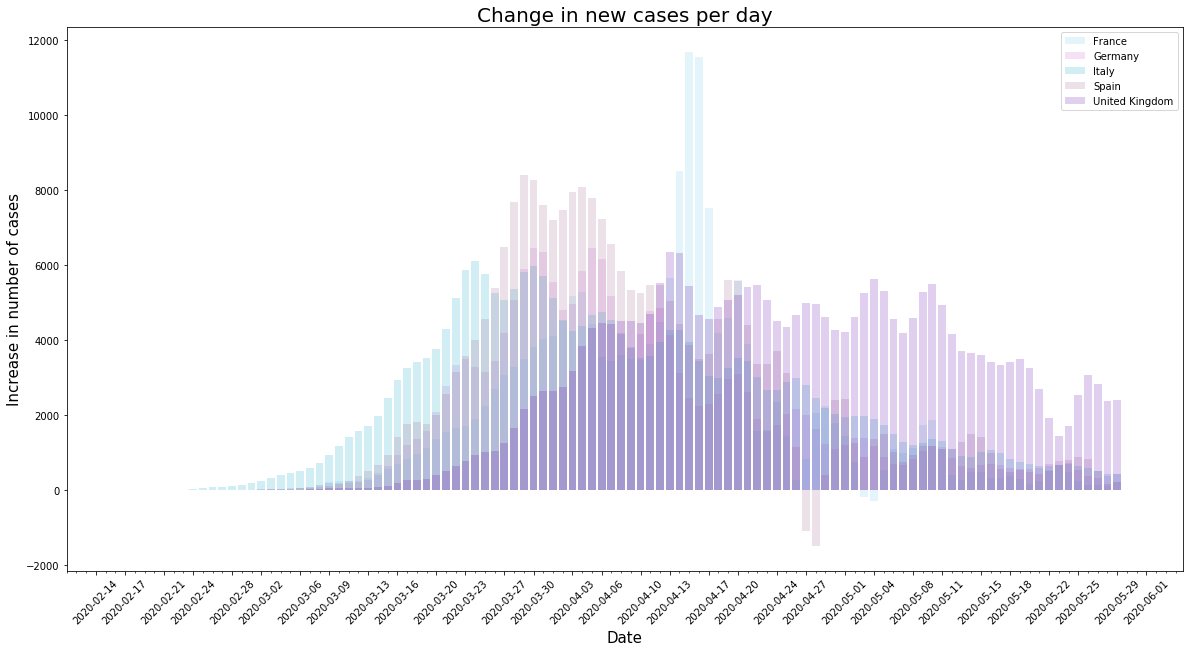

In [8]:
list_countries = ['France_Mainland', 'US_Mainland', 'Italy_Mainland', 'United Kingdom_Mainland', 'Australia_Total', 'Victoria', 'New South Wales', 'Spain_Mainland']
list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain']#, 'Netherlands', 'Sweden']
#list_countries = ['Spain']
#if 'US_Mainland' in list_countries: list_countries.remove('US_Mainland')
#list_countries = ['Australia_Total', 'Victoria', 'New South Wales']
colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())
axislabels = ["Increase in number of cases", "Change in new cases per day"]
filtering = True
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotDailyChanges(df_daily_change_conf, list_countries, colourList, axislabels, filterInputs)

In [97]:
df_daily_change_conf[df_daily_change_conf['Province/State'] == 'Spain'].head()


,Province/State,Country/Region,Lat,Long,Diff_Prev_Day_22/1,Diff_Prev_Day_23/1,Diff_Prev_Day_24/1,Diff_Prev_Day_25/1,Diff_Prev_Day_26/1,Diff_Prev_Day_27/1,Diff_Prev_Day_28/1,Diff_Prev_Day_29/1,Diff_Prev_Day_30/1,Diff_Prev_Day_31/1,Diff_Prev_Day_1/2,Diff_Prev_Day_2/2,Diff_Prev_Day_3/2,Diff_Prev_Day_4/2,Diff_Prev_Day_5/2,Diff_Prev_Day_6/2,Diff_Prev_Day_7/2,Diff_Prev_Day_8/2,Diff_Prev_Day_9/2,Diff_Prev_Day_10/2,Diff_Prev_Day_11/2,Diff_Prev_Day_12/2,Diff_Prev_Day_13/2,Diff_Prev_Day_14/2,Diff_Prev_Day_15/2,Diff_Prev_Day_16/2,Diff_Prev_Day_17/2,Diff_Prev_Day_18/2,Diff_Prev_Day_19/2,Diff_Prev_Day_20/2,Diff_Prev_Day_21/2,Diff_Prev_Day_22/2,Diff_Prev_Day_23/2,Diff_Prev_Day_24/2,Diff_Prev_Day_25/2,Diff_Prev_Day_26/2,Diff_Prev_Day_27/2,Diff_Prev_Day_28/2,Diff_Prev_Day_29/2,Diff_Prev_Day_1/3,Diff_Prev_Day_2/3,Diff_Prev_Day_3/3,Diff_Prev_Day_4/3,Diff_Prev_Day_5/3,Diff_Prev_Day_6/3,Diff_Prev_Day_7/3,Diff_Prev_Day_8/3,Diff_Prev_Day_9/3,Diff_Prev_Day_10/3,Diff_Prev_Day_11/3,Diff_Prev_Day_12/3,Diff_Prev_Day_13/3,Diff_Prev_Day_14/3,Diff_Prev_Day_15/3,Diff_Prev_Day_16/3,Diff_Prev_Day_17/3,Diff_Prev_Day_18/3,Diff_Prev_Day_19/3,Diff_Prev_Day_20/3,Diff_Prev_Day_21/3,Diff_Prev_Day_22/3,Diff_Prev_Day_23/3,Diff_Prev_Day_24/3,Diff_Prev_Day_25/3,Diff_Prev_Day_26/3,Diff_Prev_Day_27/3,Diff_Prev_Day_28/3,Diff_Prev_Day_29/3,Diff_Prev_Day_30/3,Diff_Prev_Day_31/3,Diff_Prev_Day_1/4,Diff_Prev_Day_2/4,Diff_Prev_Day_3/4,Diff_Prev_Day_4/4,Diff_Prev_Day_5/4,Diff_Prev_Day_6/4,Diff_Prev_Day_7/4,Diff_Prev_Day_8/4,Diff_Prev_Day_9/4,Diff_Prev_Day_10/4,Diff_Prev_Day_11/4,Diff_Prev_Day_12/4,Diff_Prev_Day_13/4,Diff_Prev_Day_14/4,Diff_Prev_Day_15/4,Diff_Prev_Day_16/4,Diff_Prev_Day_17/4,Diff_Prev_Day_18/4,Diff_Prev_Day_19/4,Diff_Prev_Day_20/4,Diff_Prev_Day_21/4,Diff_Prev_Day_22/4,Diff_Prev_Day_23/4,Diff_Prev_Day_24/4,Diff_Prev_Day_25/4,Diff_Prev_Day_26/4,Diff_Prev_Day_27/4,Diff_Prev_Day_28/4,Diff_Prev_Day_29/4,Diff_Prev_Day_30/4,Diff_Prev_Day_1/5,Diff_Prev_Day_2/5,Diff_Prev_Day_3/5,Diff_Prev_Day_4/5,Diff_Prev_Day_5/5,Diff_Prev_Day_6/5,Diff_Prev_Day_7/5,Diff_Prev_Day_8/5,Diff_Prev_Day_9/5,Diff_Prev_Day_10/5,Diff_Prev_Day_11/5,Diff_Prev_Day_12/5,Diff_Prev_Day_13/5,Diff_Prev_Day_14/5,Diff_Prev_Day_15/5,Diff_Prev_Day_16/5,Diff_Prev_Day_17/5,Diff_Prev_Day_18/5,Diff_Prev_Day_19/5,Diff_Prev_Day_20/5,Diff_Prev_Day_21/5,Diff_Prev_Day_22/5,Diff_Prev_Day_23/5,Diff_Prev_Day_24/5,Diff_Prev_Day_25/5,Diff_Prev_Day_26/5,Diff_Prev_Day_27/5
0,Spain,Spain,40.0,-4.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,7,2,17,13,39,36,45,57,37,141,100,173,400,622,582,0,2955,1159,1407,2144,1806,2162,4053,2447,4964,3394,6368,4749,9630,8271,7933,7516,6875,7846,7967,8195,7947,7134,6969,5478,5029,5267,6278,5002,5051,4754,3804,3268,2442,5103,7304,5891,887,6948,1536,3968,4211,4635,-10034,2915,1729,1831,1308,2144,518,1781,1366,884,545,1318,996,1122,1410,721,772,3086,594,661,849,643,515,0,908,431,518,482,1787,466,482,-372,859,0


In [28]:
df_daily_change_conf.head()

,Province/State,Country/Region,Lat,Long,Diff_Prev_Day_22/1,Diff_Prev_Day_23/1,Diff_Prev_Day_24/1,Diff_Prev_Day_25/1,Diff_Prev_Day_26/1,Diff_Prev_Day_27/1,Diff_Prev_Day_28/1,Diff_Prev_Day_29/1,Diff_Prev_Day_30/1,Diff_Prev_Day_31/1,Diff_Prev_Day_1/2,Diff_Prev_Day_2/2,Diff_Prev_Day_3/2,Diff_Prev_Day_4/2,Diff_Prev_Day_5/2,Diff_Prev_Day_6/2,Diff_Prev_Day_7/2,Diff_Prev_Day_8/2,Diff_Prev_Day_9/2,Diff_Prev_Day_10/2,Diff_Prev_Day_11/2,Diff_Prev_Day_12/2,Diff_Prev_Day_13/2,Diff_Prev_Day_14/2,Diff_Prev_Day_15/2,Diff_Prev_Day_16/2,Diff_Prev_Day_17/2,Diff_Prev_Day_18/2,Diff_Prev_Day_19/2,Diff_Prev_Day_20/2,Diff_Prev_Day_21/2,Diff_Prev_Day_22/2,Diff_Prev_Day_23/2,Diff_Prev_Day_24/2,Diff_Prev_Day_25/2,Diff_Prev_Day_26/2,Diff_Prev_Day_27/2,Diff_Prev_Day_28/2,Diff_Prev_Day_29/2,Diff_Prev_Day_1/3,Diff_Prev_Day_2/3,Diff_Prev_Day_3/3,Diff_Prev_Day_4/3,Diff_Prev_Day_5/3,Diff_Prev_Day_6/3,Diff_Prev_Day_7/3,Diff_Prev_Day_8/3,Diff_Prev_Day_9/3,Diff_Prev_Day_10/3,Diff_Prev_Day_11/3,Diff_Prev_Day_12/3,Diff_Prev_Day_13/3,Diff_Prev_Day_14/3,Diff_Prev_Day_15/3,Diff_Prev_Day_16/3,Diff_Prev_Day_17/3,Diff_Prev_Day_18/3,Diff_Prev_Day_19/3,Diff_Prev_Day_20/3,Diff_Prev_Day_21/3,Diff_Prev_Day_22/3,Diff_Prev_Day_23/3,Diff_Prev_Day_24/3,Diff_Prev_Day_25/3,Diff_Prev_Day_26/3,Diff_Prev_Day_27/3,Diff_Prev_Day_28/3,Diff_Prev_Day_29/3,Diff_Prev_Day_30/3,Diff_Prev_Day_31/3,Diff_Prev_Day_1/4,Diff_Prev_Day_2/4,Diff_Prev_Day_3/4,Diff_Prev_Day_4/4,Diff_Prev_Day_5/4,Diff_Prev_Day_6/4,Diff_Prev_Day_7/4,Diff_Prev_Day_8/4,Diff_Prev_Day_9/4,Diff_Prev_Day_10/4,Diff_Prev_Day_11/4,Diff_Prev_Day_12/4,Diff_Prev_Day_13/4,Diff_Prev_Day_14/4,Diff_Prev_Day_15/4,Diff_Prev_Day_16/4,Diff_Prev_Day_17/4,Diff_Prev_Day_18/4,Diff_Prev_Day_19/4,Diff_Prev_Day_20/4,Diff_Prev_Day_21/4,Diff_Prev_Day_22/4,Diff_Prev_Day_23/4,Diff_Prev_Day_24/4,Diff_Prev_Day_25/4,Diff_Prev_Day_26/4,Diff_Prev_Day_27/4,Diff_Prev_Day_28/4,Diff_Prev_Day_29/4,Diff_Prev_Day_30/4,Diff_Prev_Day_1/5,Diff_Prev_Day_2/5,Diff_Prev_Day_3/5,Diff_Prev_Day_4/5,Diff_Prev_Day_5/5,Diff_Prev_Day_6/5,Diff_Prev_Day_7/5,Diff_Prev_Day_8/5,Diff_Prev_Day_9/5,Diff_Prev_Day_10/5,Diff_Prev_Day_11/5,Diff_Prev_Day_12/5,Diff_Prev_Day_13/5,Diff_Prev_Day_14/5,Diff_Prev_Day_15/5,Diff_Prev_Day_16/5,Diff_Prev_Day_17/5,Diff_Prev_Day_18/5,Diff_Prev_Day_19/5,Diff_Prev_Day_20/5,Diff_Prev_Day_21/5,Diff_Prev_Day_22/5,Diff_Prev_Day_23/5,Diff_Prev_Day_24/5,Diff_Prev_Day_25/5
0,Afghanistan_Mainland,Afghanistan,33.0000,65.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,4.0,5.0,5.0,1.0,0.0,0.0,2.0,0.0,16.0,0.0,34.0,10.0,10.0,16.0,0.0,10.0,50.0,4.0,63.0,36.0,8.0,18.0,50.0,18.0,56.0,21.0,40.0,37.0,34.0,52.0,58.0,49.0,70.0,56.0,66.0,27.0,63.0,30.0,66.0,84.0,103.0,72.0,112.0,68.0,172.0,125.0,111.0,232.0,164.0,134.0,235.0,190.0,330.0,168.0,171.0,215.0,255.0,369.0,285.0,276.0,263,413,414,349,262,408,581,492,531,540,782,584,591
0,Afghanistan_Total,Afghanistan,33.0000,65.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,4.0,5.0,5.0,1.0,0.0,0.0,2.0,0.0,16.0,0.0,34.0,10.0,10.0,16.0,0.0,10.0,50.0,4.0,63.0,36.0,8.0,18.0,50.0,18.0,56.0,21.0,40.0,37.0,34.0,52.0,58.0,49.0,70.0,56.0,66.0,27.0,63.0,30.0,66.0,84.0,103.0,72.0,112.0,68.0,172.0,125.0,111.0,232.0,164.0,134.0,235.0,190.0,330.0,168.0,171.0,215.0,255.0,369.0,285.0,276.0,263,413,414,349,262,408,581,492,531,540,782,584,591
0,Albania_Mainland,Albania,41.1533,20.1683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,11.0,10.0,5.0,4.0,9.0,4.0,4.0,5.0,6.0,6.0,13.0,15.0,19.0,23.0,28.0,12.0,11.0,15.0,11.0,20.0,16.0,18.0,27.0,29.0,28.0,16.0,6.0,17.0,9.0,7.0,17.0,13.